In [1]:
import cosmology as cosmo, basic, tqdm
from matplotlib.pyplot import *
from scipy.integrate import quad, dblquad
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
def xHlogxH(xe):
    if 1.-xe<1e-6:
        return 0.
    else:
        return (1.-xe)*np.log(1.-xe)

In [3]:
def Pr(R,R0,sigma=np.log(2.)):
    return 1./(R*np.sqrt(2*np.pi*sigma**2)) * np.exp(-(np.log(R/R0))**2/(2.*sigma**2))

In [4]:
def Wth(x):
    return 3./x**3 * (np.sin(x)-x*np.cos(x))

In [5]:
def Fk(k,R0):
    I1 = lambda R: Pr(R,R0)*(4*np.pi*R**3/3.)**2*Wth(k*R)**2
    I2 = lambda R: Pr(R,R0)*4*np.pi*R**3/3.
    neum = quad(I1,0.,2e2)[0]
    deno = quad(I2,0.,2e2)[0]
    return neum/deno

In [6]:
def Gk_muint(k,K,Pk):
    I = lambda mu: Pk( np.sqrt(k**2-2*k*K*mu+K**2) )
    return quad(I,-1.,1.)[0]

In [7]:
def Gk(k,R0,Pk):
    vFk = np.vectorize(Fk)
    vGkint = np.vectorize(Gk_muint)
    Ki = np.logspace(-3,1,11)
    dK = Ki[1:]-Ki[:-1]
    I = np.sum(dK*Ki[:-1]**2*vGkint(k,Ki[:-1],Pk)/(2*np.pi)**2*vFk(Ki[:-1],R0))
    #Gk_int = lambda mu, K: K**2*Pk( np.sqrt(k**2-2*k*K*mu+K**2) ) * Fk(K,R0) / (2*np.pi)**2
    #I = dblquad( Gk_int, 1e-3, 1, lambda x:-1, lambda x:1 )[0]
    return I

In [8]:
def Ik(k,R0):
    I1 = lambda R: Pr(R,R0) * R**3 * Wth(k*R)
    I2 = lambda R: Pr(R,R0) * R**3
    neum = quad(I1,0.,2e2)[0]
    deno = quad(I2,0.,2e2)[0]
    return neum/deno

In [9]:
def xe_sym(z,zre=8.,Dz=4.):
    y = np.power(1.+z,1.5)
    yre = np.power(1.+zre,1.5)
    Dy  = 1.5*np.sqrt(1.+zre)*Dz
    return .5*(1.-np.tanh((y-yre)/Dy))

In [10]:
def xe_asym(z,alpha=6.,zend=6.):
    if z < zend:
        return 1.
    if z >= zend and z<20.:
        return np.power((20.-z)/(20.-zend),alpha)
    if z >= 20:
        return 1e-30

In [11]:
cps = {'H0':67.5,'Om':.31,'Ov':.69,'w0':-1.,'wa':0.}
Obh2 = .0223
bias = 6.
R0 = 10.
model = 'TH'
alpha = 0.

In [12]:
k, pk0 = np.loadtxt('../data/other/Pklin.dat',unpack=True)
k *= cps['H0']/100.
pk0 /= (cps['H0']/100.)**3
Pk = spline(k,pk0)

In [13]:
zi = np.linspace(1e-4,20.,2000)
Hzi = basic.cosmofuncs.hubble(zi,**cps)
rzi = basic.cosmofuncs.dist_comoving(zi,**cps)
Dzi = basic.cosmofuncs.growth_factor(zi,normed=True,**cps)
Hz = spline( zi, Hzi )
rz = spline( zi, rzi )
Dz = spline( zi, Dzi )

In [14]:
# define functions

fac = 7.477e-30*3e24*Obh2 # Eq.(3.43) of Dodelson's Modern Cosmology

Kz  = lambda z: fac**2*(1+z)**4/rz(z)**2/Hz(z)
if model=='AS': xe = lambda z: xe_asym(z)
if model=='TH': xe = lambda z: xe_sym(z)

# tau
I = lambda z: (1+z)**2/Hz(z) * xe(z)
print('tau', quad(I,0.,100.)[0] * fac)

l  = np.linspace(1,3000,100)
cl = np.zeros((2,np.size(l)))

Rz = lambda z: R0*np.power(10.,alpha*(xe(z)-.5))
if alpha==0.: 
    Rz = lambda z: R0

for i, L in enumerate(tqdm.tqdm(l)):
    k  = lambda z: L/rz(z)
    Pm = lambda z: Dz(z)**2*Pk(k(z))
    P1 = lambda z: xe(z) * (1-xe(z)) * ( Fk(k(z),Rz(z)) + Gk(k(z),Rz(z),Pm) )
    P2 = lambda z: ( xHlogxH(xe(z))*bias*Ik(k(z),Rz(z)) - xe(z) )**2 * Pm(z)
    I0 = lambda z: Kz(z)*(P1(z)+P2(z))
    I1 = lambda z: Kz(z)*P1(z)
    cl[0,i] = quad(I0,0.,100.)[0]
    cl[1,i] = quad(I1,0.,100.)[0]
    #print('Cl',L,cl[:,i])

np.savetxt('tt_'+model+'_R'+str(R0)+'_a'+str(alpha)+'.dat',np.concatenate((l[None,:],cl)).T)

  0%|          | 0/100 [00:00<?, ?it/s]

tau 0.06860015693257339


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.
 51%|█████     | 51/100 [09:20<07:35,  9.30s/it]/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-p

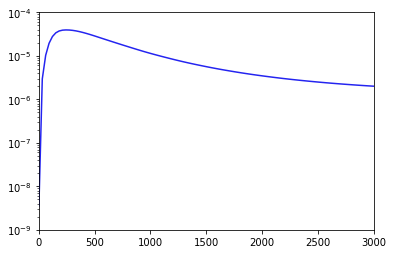

In [15]:
xlim(1,3000)
ylim(1e-9,1e-4)
yscale('log')
plot(l,l**2*cl[0,:]/2/np.pi)

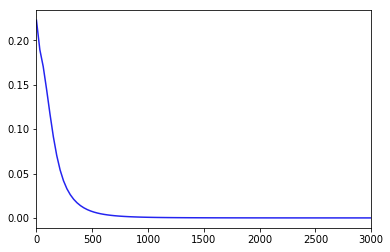

In [16]:
xlim(1,3000)
plot(l,1e7*cl[0,:])